<a href="https://www.kaggle.com/code/mrafraim/dl-day-23-cnn-training-internals?scriptVersionId=289944055" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Day 23: CNN Training Internals

Welcome to Day 23!

Today you will understand:
- What forward pass really does in CNNs
- How backward pass updates filters
- How optimizer changes weights
- How to visualize learned convolution filters

If you found this notebook helpful, your **<b style="color:red;">UPVOTE</b>** would be greatly appreciated! It helps others discover the work and supports continuous improvement.

---

# CNN Training Loop

For each batch:
1. Forward pass → predictions
2. Compute loss
3. Backward pass → gradients
4. Optimizer step → update weights

Repeat for many epochs.

CNNs learn by adjusting filters, not pixels.


# Reusing Previous CNN Model (from Day 22)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),                 
    transforms.Normalize((0.1307,), (0.3081,))
])


In [4]:
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 339kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.72MB/s]


In [5]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True)

test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False)

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  
        
        return x


# Forward Pass

- Input image enters CNN
- Filters slide → feature maps
- Activations introduce non-linearity
- Pooling reduces size
- Fully connected layers produce scores

Mathematically:
$$
\text{Output} = f(W * X + b)
$$

Forward pass = prediction


# Backward Pass

Backward pass:
- Computes gradients of loss w.r.t parameters
- Uses chain rule
- Adjusts filters to reduce future loss

Key idea:
> Filters that helped prediction → strengthened  
> Filters that hurt prediction → weakened


# Optimizer

Optimizer updates weights using gradients.

Example (Gradient Descent):
$$
W := W - \eta \frac{\partial L}{\partial W}
$$

Where:
- $W$ = weights
- $\eta$ = learning rate
- $L$ = loss

Adam optimizer:
- Adaptive learning rates
- Faster convergence
- Industry standard


In [7]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# One Training Step

In [8]:
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)

optimizer.zero_grad()         # clear old gradients
outputs = model(images)       # forward pass
loss = criterion(outputs, labels)
loss.backward()               # backward pass
optimizer.step()              # update filters

loss.item()


2.2988879680633545

In [9]:
# Inspect gradients of first convolution layer
model.conv1.weight.grad.shape


torch.Size([16, 1, 3, 3])

| Dimension | Meaning                          |
| --------- | -------------------------------- |
| 16        | Number of filters (out_channels) |
| 1         | Input channels                   |
| 3         | Kernel height                    |
| 3         | Kernel width                     |


Each filter has its own gradient matrix.
This is how CNNs learn patterns.


# Why Visualize Filters?

Filters tell us:
- What patterns CNN is detecting
- Whether training is meaningful
- Whether learning collapsed

Early filters:
- Edges
- Curves
- Simple strokes


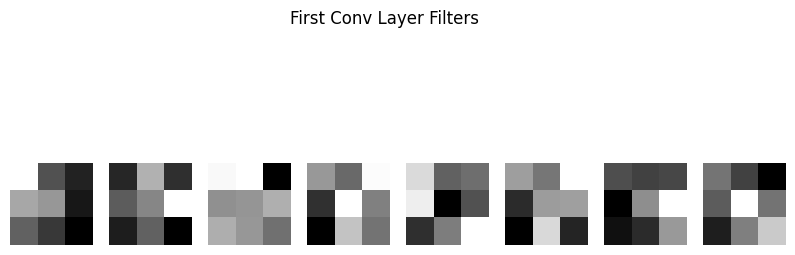

In [10]:
def visualize_filters(conv_layer):
    filters = conv_layer.weight.data.cpu()
    num_filters = filters.shape[0]

    plt.figure(figsize=(10,4))
    for i in range(min(num_filters, 8)):
        plt.subplot(1,8,i+1)
        plt.imshow(filters[i,0,:,:], cmap='gray')
        plt.axis('off')
    plt.suptitle("First Conv Layer Filters")
    plt.show()

visualize_filters(model.conv1)


You are literally seeing what the CNN sees.

We visualize filters to see the patterns the CNN is trying to learn. Each filter is like a tiny detector for edges, lines, or strokes. By looking at them, we can check if the network is actually learning meaningful features from the data, or if something is going wrong during training

# Filter Evolution

- Before training → random noise
- After training → structured edges
- More epochs → sharper patterns

CNNs discover vision primitives automatically.


# Full Training Loop

In [11]:
epochs = 5

for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")


Epoch 1/5 | Loss: 0.0269
Epoch 2/5 | Loss: 0.2306
Epoch 3/5 | Loss: 0.1465
Epoch 4/5 | Loss: 0.0049
Epoch 5/5 | Loss: 0.0486


# Common CNN Training Mistakes

- Forgetting `optimizer.zero_grad()`
- Wrong tensor shape
- Too high learning rate
- Not using `eval()` during testing
- Misinterpreting loss vs accuracy


# Key Takeaways from Day 23

- Forward pass makes predictions
- Backward pass adjusts filters
- Optimizer updates weights
- CNNs learn visual patterns automatically
- Filter visualization builds intuition

---

<p style="text-align:center; font-size:18px;">
© 2026 Mostafizur Rahman
</p>
